In [1]:
%matplotlib inline
from spacepy import pycdf
from matplotlib import pyplot as plt
from scipy import interpolate
import numpy as np
import pycwt
import datetime
from scipy.stats import norm
from scipy.integrate import quad

def moving_average(x, w):
    return np.convolve(x, np.ones(w)/ w, 'same') 

def get_gaussian_window(n):
    # better use erf(x)
    res = [quad(norm.pdf,-3+i*6/n,-3+(i+1)*6/n)[0] for i in range(n)]
    return np.array(res)

def gauss_moving_average(x, w):
    return np.convolve(x, get_gaussian_window(w), 'same')

# see timeseries

In [2]:
mag_data = pycdf.CDF('data/wi_h0_mfi_20130117_v05.cdf')

epoch3sec_mag = mag_data['Epoch3'][...]
bGSE3sec = mag_data['B3GSE'][...]
bTotal3sec = mag_data['B3F1'][...]
bGSE3sec[bGSE3sec<-10000] = np.nan
bTotal3sec[bTotal3sec<-10000] = np.nan

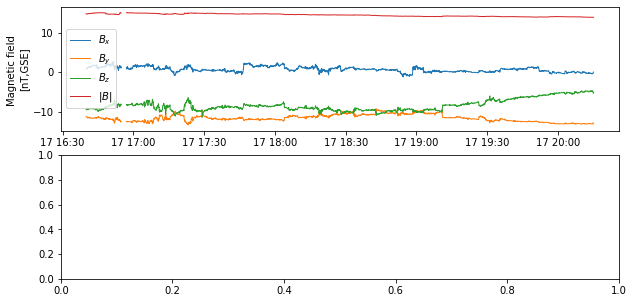

In [3]:
START=20000
END = -4500

fig, axes = plt.subplots(2,figsize=(10,5))
ax = axes[0]
ax.plot(epoch3sec_mag[START:END],bGSE3sec[START:END,0],label='$B_x$',linewidth=1)
ax.plot(epoch3sec_mag[START:END],bGSE3sec[START:END,1],label='$B_y$',linewidth=1)
ax.plot(epoch3sec_mag[START:END],bGSE3sec[START:END,2],label='$B_z$',linewidth=1)
ax.plot(epoch3sec_mag[START:END],bTotal3sec[START:END],label='$|B|$',linewidth=1)
ax.set_ylabel('Magnetic field \n[nT,GSE]')
ax.legend();

# extract interval of interest, bg magnetic field coordinate

In [4]:
# exctract interval of interest
epoch_interested = epoch3sec_mag[START:END]
bGSE_interested = bGSE3sec[START:END]
bTotal_interested = bTotal3sec[START:END]

width = 20 # the width of the gaussian window
bGSE_interested_avg = np.zeros(bGSE_interested.shape)
for i in range(3):
    bGSE_interested_avg[:,i] = gauss_moving_average(bGSE_interested[:,i],width)
    bGSE_interested_avg[:width//2,i] = np.nan
    bGSE_interested_avg[-width//2:,i] = np.nan
delta_bGSE_interested = bGSE_interested - bGSE_interested_avg
(np.isnan(bGSE_interested_avg)).sum()

252

In [5]:
delta_B_in_B_local_coor_arr = np.zeros(delta_bGSE_interested.shape)
for index in range(delta_bGSE_interested.shape[0]):
    B_bg = bGSE_interested[index]
    B = bGSE_interested_avg[index]
    delta_B = delta_bGSE_interested[index]
#     print(delta_B)

    x_cross_B_bg = np.cross((1,0,0),B_bg)
    B_bg_cross_xcrossBbg = np.cross(B_bg,x_cross_B_bg)

    norm = np.linalg.norm

    e_Bbg = B_bg / norm(B_bg) # z
    e_xcrossBbg = x_cross_B_bg / norm(x_cross_B_bg) # x
    e_Bbg_cross_xcrossBbg = B_bg_cross_xcrossBbg / norm(B_bg_cross_xcrossBbg) # y
#     print(e_Bbg,e_xcrossBbg,e_Bbg_cross_xcrossBbg)
#     print(e_Bbg@e_xcrossBbg,e_xcrossBbg@e_Bbg_cross_xcrossBbg,e_Bbg_cross_xcrossBbg@e_Bbg)

    delta_B_in_B_local_coor = np.zeros(delta_B.shape)
    delta_B_in_B_local_coor[2] = np.dot(delta_B,e_Bbg)
    delta_B_in_B_local_coor[0] = np.dot(delta_B,e_xcrossBbg)
    delta_B_in_B_local_coor[1] = np.dot(delta_B,e_Bbg_cross_xcrossBbg)
#     print(delta_B_in_B_local_coor)
    delta_B_in_B_local_coor_arr[index] = delta_B_in_B_local_coor

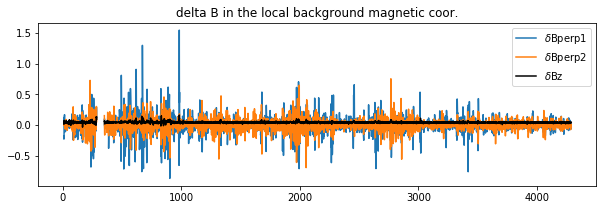

In [6]:
fig = plt.figure(figsize=(10,3))
plt.plot(delta_B_in_B_local_coor_arr[:,0],label='$\\delta$Bperp1')
plt.plot(delta_B_in_B_local_coor_arr[:,1],label='$\\delta$Bperp2')
plt.plot(delta_B_in_B_local_coor_arr[:,2],color='k',label='$\\delta$Bz')
plt.legend();
plt.title('delta B in the local background magnetic coor.');

# wavelet transform

In [7]:
# padding with zero
delta_B_in_B_local_coor_arr[np.isnan(delta_B_in_B_local_coor_arr)] = 0

In [8]:
# preparation for wavelet transform
dt = 3.0 # seconds
# periods = np.logspace(np.log10(6),np.log10(600),40)
periods = np.linspace(6,600,40)
freqs = 1/periods
my_morlet = pycwt.Morlet(f0=8)

In [9]:
dB_wt_x, scales_x, freqs_x, coi_x, fft_x, fftfreqs_x = pycwt.cwt(
    delta_B_in_B_local_coor_arr[:, 0], dt, wavelet=my_morlet, freqs=freqs)
dB_wt_y, scales_y, freqs_y, coi_y, fft_y, fftfreqs_y = pycwt.cwt(
    delta_B_in_B_local_coor_arr[:, 1], dt, wavelet=my_morlet, freqs=freqs)
Px = abs(dB_wt_x)**2
Py = abs(dB_wt_y)**2

# magnetic helicity 
mag_helicity = 2*((dB_wt_x*dB_wt_y.conj()).imag)/(Px+Py)

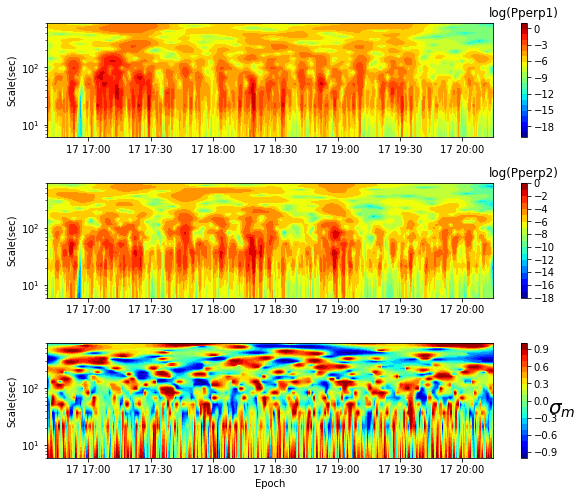

In [12]:
fig,axes = plt.subplots(3, figsize=(10,8))
plt.subplots_adjust(hspace=0.4)

contour = axes[0].contourf(epoch_interested[:,0],periods,np.log(Px),cmap='jet',levels=20)
clb = plt.colorbar(contour,ax=axes[0])
axes[0].semilogy()
clb.ax.set_title('log(Pperp1)')

contour = axes[1].contourf(epoch_interested[:,0],periods,np.log(Py),cmap='jet',levels=20)
clb = plt.colorbar(contour,ax=axes[1])
axes[1].semilogy()
clb.ax.set_title('log(Pperp2)')

contour = axes[2].contourf(epoch_interested[:,0],periods,mag_helicity,cmap='jet',levels=20)
clb = plt.colorbar(contour,ax=axes[2])
axes[2].semilogy()
clb.ax.set_ylabel('$\\sigma_m$',fontsize=20,rotation=0)

axes[0].set_ylabel('Scale(sec)')
axes[1].set_ylabel('Scale(sec)')
axes[2].set_ylabel('Scale(sec)')
axes[2].set_xlabel('Epoch');